# INTENT 2: 
# Smart Meters in London: Data Analysis and ML model (Part 2/2)

There are three main objectives in this project, as stated below:

1. Create a ML algorithm to forecast the electricity consumption for one household considering the prior smart meter data we have. Hence, we could create a Dashboard with Tableau to show the results that end-user has. 

2. Classifying our portfolio clients according to their consumption, but also according to acorn classification. 

3. Analyse the influence of the weather into our energy consumption. This last step could be performed in two ways: considering only one household, or, on the contrary, aggregating all the demand we have in our 6000 clients. 

This second jupyter notebook wants to analyse the data coming from the energy cnsumption of different users, to see how a forecast algorithm can be developed, or clustering models can be done. 

The structure of this notebook is as follows: 

1.  Electricity consumption from end-user MAC000291. TIme Series Analysis


In [1]:
# Importing libraries required for the analysis 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as dt
from sqlalchemy import create_engine 
import os
import sklearn 

# Importing libraries required for T-S analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from pandas.plotting import lag_plot
import itertools

# Seting style for matplotlib
plt.style.use('ggplot')

In [2]:
# Reading the current working directoy to see where are we writing the code. 
os.getcwd()

'/home/ingrid/Documents/DA_Ironhack/Week8/Final_Project/your-project/2.JupyterNotebooks'

In [3]:
# Reading the csv file with the information of MAC000291 end-user's electricity consumption
user_291_df = pd.read_csv('../0.Data/clean_data/MAC000291_cleaned_consumption.csv', index_col=0)

In [4]:
user_291_df.head()

,LCLid,DateTime,kWh/hh
0,MAC000291,2012-03-02 09:30:00,1.158
1,MAC000291,2012-03-02 10:00:00,1.499
2,MAC000291,2012-03-02 10:30:00,1.433
3,MAC000291,2012-03-02 11:00:00,0.510
4,MAC000291,2012-03-02 11:30:00,0.455


In [5]:
# Checking the types of the user_df 
user_291_df.dtypes

LCLid        object
DateTime     object
kWh/hh      float64
dtype: object

In [6]:
# Changing the type of DateTime column into DateTime 
user_291_df['DateTime'] = pd.to_datetime(user_291_df['DateTime'])

# Setting DateTime as index of the dataframe 
user_291_df.index = user_291_df['DateTime'].sort_index()

# Droping DateTime and LCLid columns 
user_291_df.drop(['DateTime', 'LCLid'], axis = 1, inplace = True )

In [7]:
user_291_df.head()

,kWh/hh
DateTime,
2012-03-02 09:30:00,1.158
2012-03-02 10:00:00,1.499
2012-03-02 10:30:00,1.433
2012-03-02 11:00:00,0.510
2012-03-02 11:30:00,0.455


Text(0, 0.5, 'Electricity consumption [kWh/hh]')

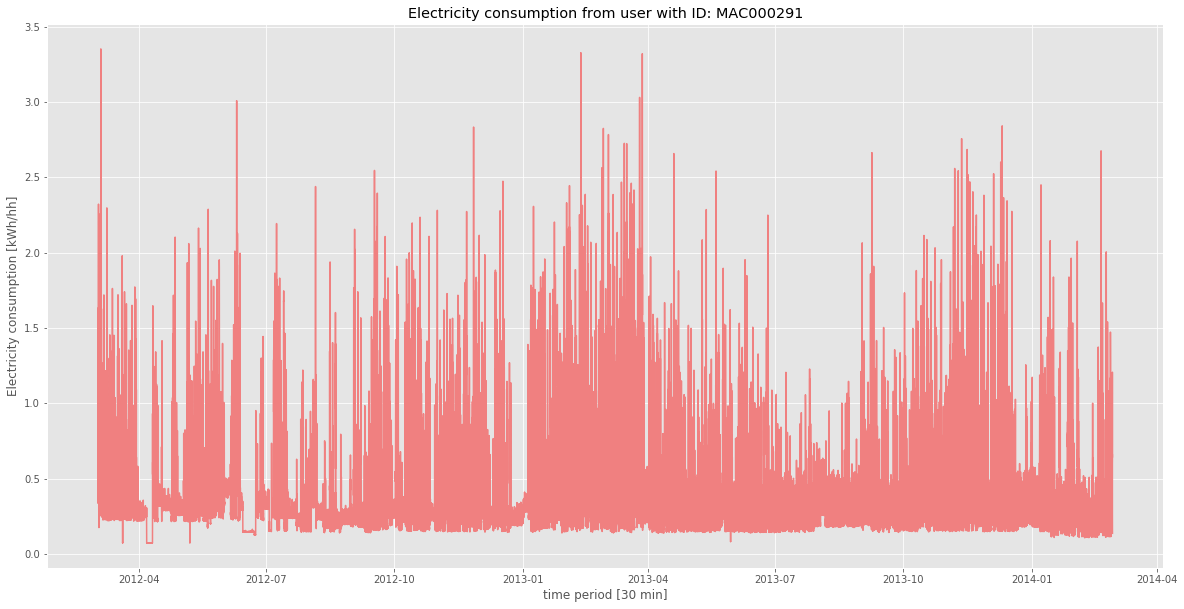

In [9]:
# Plotting the timeseries to see how the electricity consumption looks like. 
plt.figure(figsize=(20,10))
plt.plot(user_291_df.index, user_291_df['kWh/hh'], color= 'lightcoral')
plt.title('Electricity consumption from user with ID: MAC000291')
plt.xlabel('time period [30 min]')
plt.ylabel('Electricity consumption [kWh/hh]')

Text(0.5, 0, 'Time period [30 minutes]')

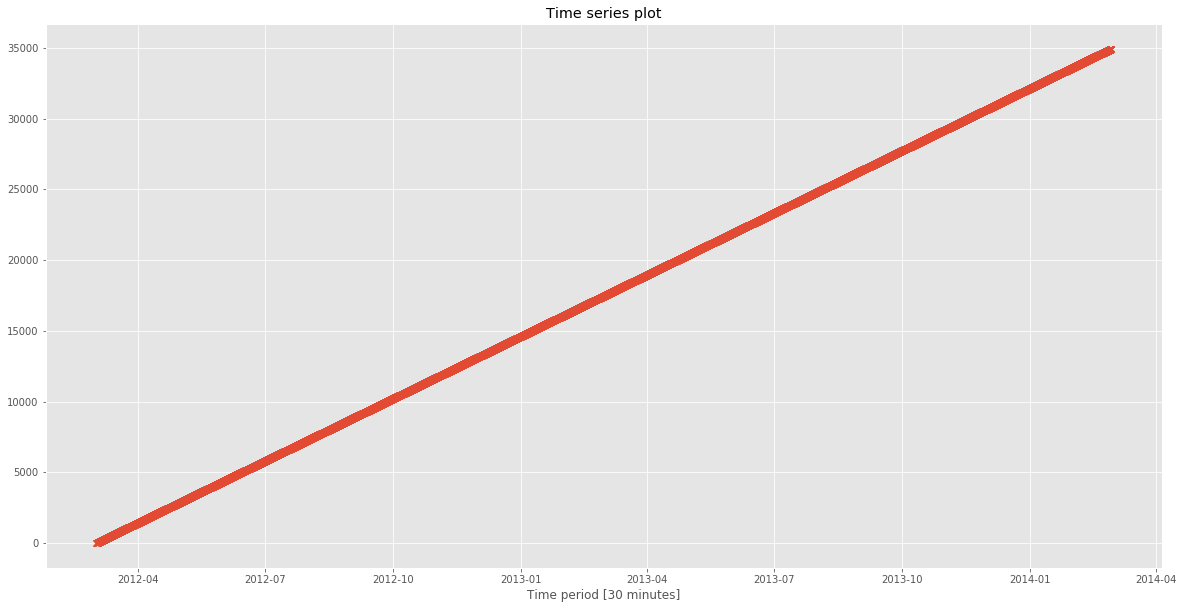

In [10]:
# Plotting to see that the evolution of the timestamp is linear and increasively, and that it is ordered. 
plt.figure(figsize=(20,10))
plt.plot(user_291_df.index, range(len(user_291_df)), 'x')
plt.title('Time series plot')
plt.xlabel('Time period [30 minutes]')

In [11]:
# Calculating the amount of data we have in 2012.
user_291_df['2012'].shape

(14620, 1)

In [12]:
# Calculating the amount of data we have in 2012.
user_291_df['2013'].shape

(17519, 1)

In [13]:
# Calculating the amount of data we have in 2012.
user_291_df['2014'].shape

(2784, 1)

In [15]:
user_291_df['2013'].head()

,kWh/hh
DateTime,
2013-01-01 00:00:00,0.228
2013-01-01 00:30:00,0.204
2013-01-01 01:00:00,0.216
2013-01-01 01:30:00,0.230
2013-01-01 02:00:00,0.258


In [16]:
user_291_df['2013'].tail()

,kWh/hh
DateTime,
2013-12-31 21:30:00,0.286
2013-12-31 22:00:00,0.274
2013-12-31 22:30:00,0.264
2013-12-31 23:00:00,0.316
2013-12-31 23:30:00,0.263


Since we want to forecast the electricity consumption of that end-user with a time resolution of 1 hour, it does not make sense to have data for more than 2 years in a timeframe of half an hour. For this reason, we will use only data from 2013 and we will resample our values into 1 hour time-period.

In [18]:
user_291_2013 = user_291_df['2013']

In [20]:
user_291_2013.head()

,kWh/hh
DateTime,
2013-01-01 00:00:00,0.228
2013-01-01 00:30:00,0.204
2013-01-01 01:00:00,0.216
2013-01-01 01:30:00,0.230
2013-01-01 02:00:00,0.258


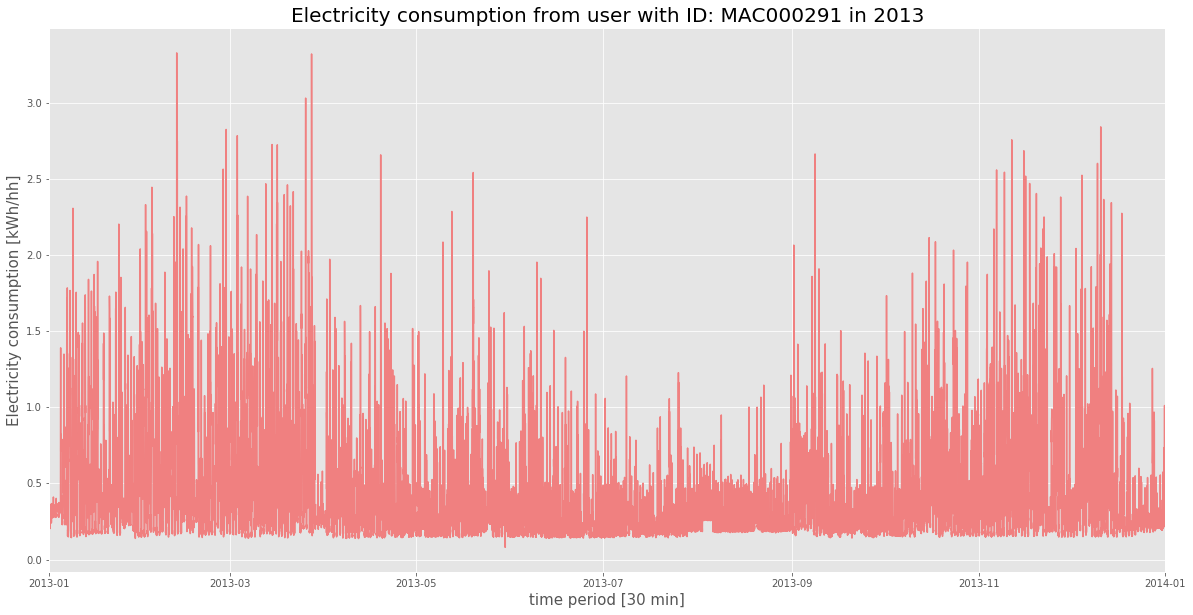

In [34]:
# Plotting the timeseries to see how the electricity consumption looks like. 
plt.figure(figsize=(20,10))
plt.plot(user_291_2013.index, user_291_2013['kWh/hh'], color= 'lightcoral')
plt.title('Electricity consumption from user with ID: MAC000291 in 2013', fontsize=20)
plt.xlabel('time period [30 min]', fontsize=15)
plt.ylabel('Electricity consumption [kWh/hh]', fontsize=15)
plt.xlim('2013-01-01 00:00:00', '2014-01-01 00:00:00')
plt.show()

In [22]:
# Resampling into 1-hour time resolution instead of 30 minutes resolution. 
user_291_2013_60=user_291_2013.resample('H').mean()

# Taking a look on what the new dataframe looks like. 
user_291_2013_60.head()

,kWh/hh
DateTime,
2013-01-01 00:00:00,0.2160
2013-01-01 01:00:00,0.2230
2013-01-01 02:00:00,0.2495
2013-01-01 03:00:00,0.2240
2013-01-01 04:00:00,0.2120


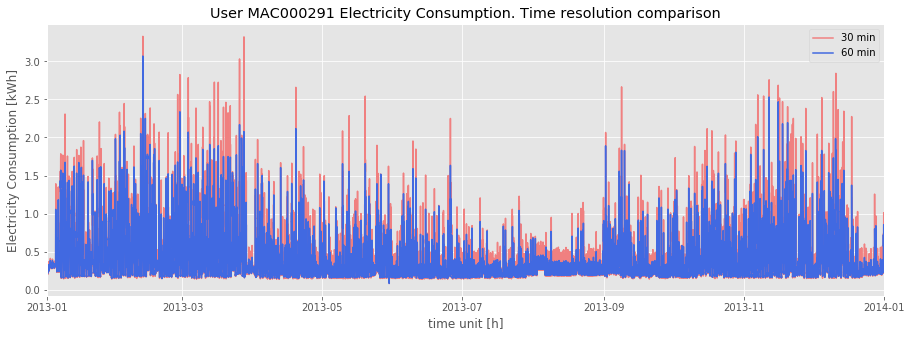

In [27]:
# Plotting both time-scale resolution 
plt.figure(figsize=(15,5))
plt.plot(user_291_2013, color='lightcoral')
plt.plot(user_291_2013_60, color='royalblue' )
plt.legend(['30 min', '60 min'], loc='upper right')
plt.title('User MAC000291 Electricity Consumption. Time resolution comparison')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-01-01 00:00:00', '2014-01-01 00:00:00')
plt.show()

### 1.2. Time-Series Preprocessing

Before creating a model to forecast the electricity consumption based on a TS model, we need to answer some questions. 

1. Is the electricity consumption autocorrelated? 
2. Is there a seasonality?
3. Is it stationary? 

#### Dick-Fulley Test for stationarity